## Побудова базової моделі

In [1]:
import json
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table

from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

from models.model.xgboost_model import XGBModel
from models.model.logistic_regression_model import LogisticRegressionModel
from sklearn.feature_extraction.text import CountVectorizer
from features.cloud_text_vectorizer import CountTextVectorizer
from features.tfidf_text_vectorizer import TfidfTextVectorizer
from preprocessing.cleaning.text_cleaning import process_text
from preprocessing.cleaning.data_process import process_date
from utils.setup import setup


%load_ext autoreload
%autoreload 2

In [3]:
setup()
is_req_store = False

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\altsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\altsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
init_df = pd.read_csv("../data/raw/fake_news_full_data.csv")

In [5]:
init_df.head(5)

,Unnamed: 0,title,text,date,is_fake
0,0,Earthquake hits off Papua New Guinea,LONDON (Reuters) - A magnitude 5.9 earthquake ...,"September 17, 2017",0
1,1,CINDY MCCAIN Reportedly Accepts Trump Administ...,The Hill released controversial comments sore ...,"Jun 12, 2017",1
2,2,Prosecutors say ex-House Speaker Hastert sexua...,(Reuters) - Former U.S. House Speaker Dennis H...,"April 9, 2016",0
3,3,Romanian protesters halt building of Xmas fair...,BUCHAREST (Reuters) - Romanian protesters clas...,"December 2, 2017",0
4,4,"Congo elected to U.N. rights council; Britain,...",UNITED NATIONS (Reuters) - Democratic Republic...,"October 16, 2017",0


In [6]:
init_df.shape

(44680, 5)

In [7]:
raw_df = init_df.copy()

Оскільки датасет може сістити дублікати даних - перевіримо і видалимо за наявності

In [8]:
duplicates = raw_df['text'].value_counts()[raw_df['text'].value_counts() > 1]
duplicates.shape

(4945,)

In [9]:
raw_df.drop(raw_df[raw_df['text'] == duplicates.index.tolist()[0]].index, inplace=True)
raw_df = raw_df.drop_duplicates(subset=['text'], ignore_index=True)
raw_df = process_date(raw_df)
raw_df.shape

Removed 1 rows


(38639, 6)

In [10]:
df = raw_df.copy()
df.shape

(38639, 6)

In [11]:
df["full_text"] = df["title"] + " " + df["text"]
df = df.drop([col for col in ["title", "text", "date"] if col in df.columns], axis=1)

In [12]:
df.head(5)

,Unnamed: 0,is_fake,date_parsed,full_text
0,0,0,2017-09-17,Earthquake hits off Papua New Guinea LONDON (R...
1,1,1,2017-06-12,CINDY MCCAIN Reportedly Accepts Trump Administ...
2,2,0,2016-04-09,Prosecutors say ex-House Speaker Hastert sexua...
3,3,0,2017-12-02,Romanian protesters halt building of Xmas fair...
4,4,0,2017-10-16,"Congo elected to U.N. rights council; Britain,..."


Маємо окремо подані заголовки та тести, врахування цього є важливим для класифікації фейкових новин, оскільки заголовки можуть містити сильні емоційні чи маніпулятивні елементи, а текст може давати більше контексту, який дозволяє визначити, чи новина є достовірною.

Але, через те, що в даному ноутбуці будується перша базова модель, тож на даному етапі, не будемо додавати ніяких спеціальних методів обробки заголовка окремо, а лише об'єднаємо його з основним текстом.

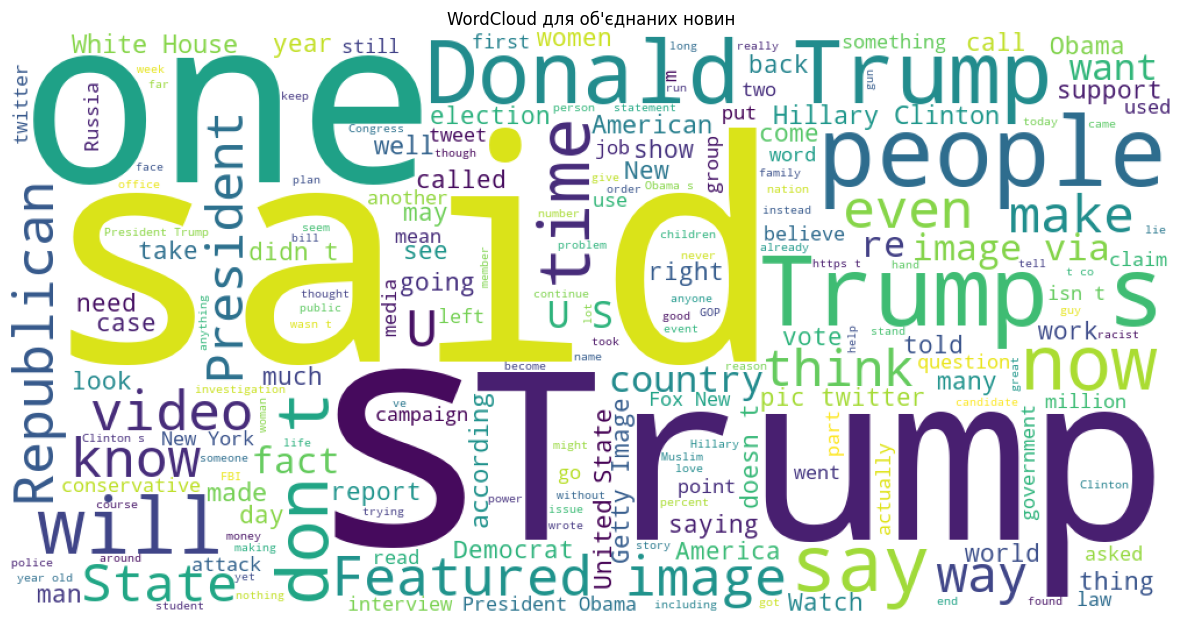

In [13]:
def wordcloud(corpus, title):
    wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(" ".join(corpus))
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis("off")
    plt.show()


wordcloud(df[df['is_fake'] == 1]['full_text'], "WordCloud для об'єднаних новин")

In [14]:
input_cols = ["full_text", "date_parsed"]
target_col = "is_fake"

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df[input_cols], df[target_col], test_size=0.2, random_state=42,
                                                    stratify=df[target_col])

In [16]:
count_vectorizer = CountTextVectorizer(
    text_column="full_text",
    tokenizer=process_text,
    max_features=4000,
    min_df=3
)

X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [17]:
def evaluate_model(model):
    model.display_confusion_matrix()
    model.display_metrics()

In [18]:
log_reg_model_count = LogisticRegressionModel(X_train=X_train_count, y_train=y_train, X_val=X_test_count,
                                              y_val=y_test).fit().predict()

Running cross-validation before training...
Cross-validation f1: 0.9765 ± 0.0008


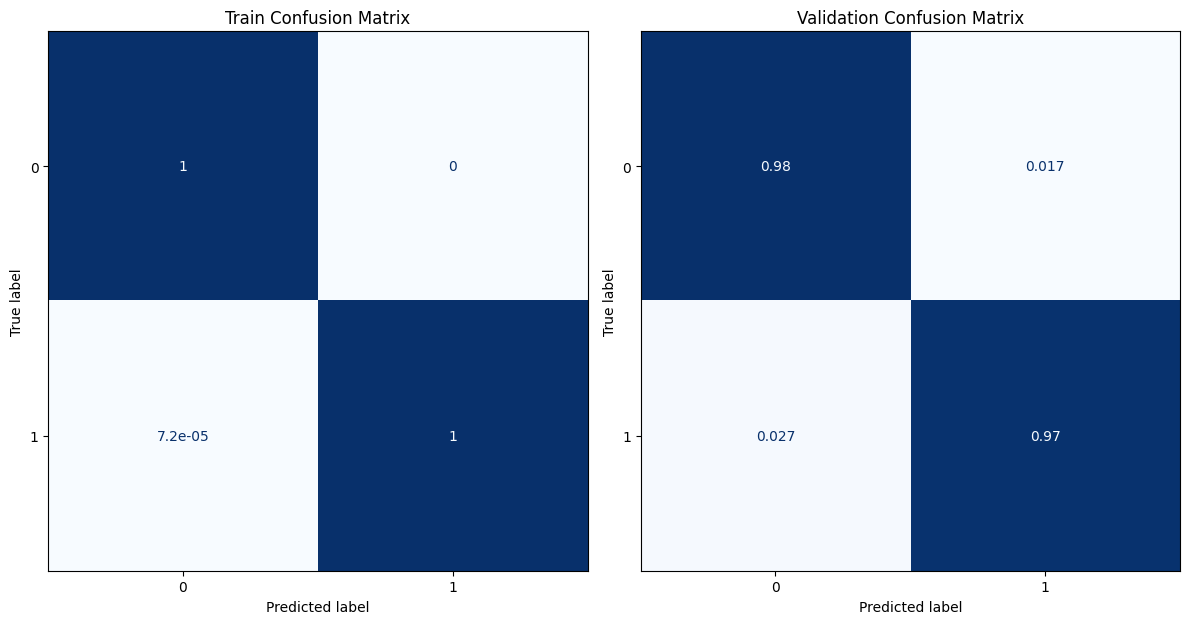

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      1.0000 │           0.9761 │
│ roc_auc  │      1.0000 │           0.9935 │
└──────────┴─────────────┴──────────────────┘

Cross-validation Results:

          Cross-validation Metrics          
┏━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Metric ┃ Mean Score ┃ Standard Deviation ┃
┡━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ f1     │     0.9765 │             0.0008 │
└────────┴────────────┴────────────────────┘

In [19]:
evaluate_model(log_reg_model_count)

Застосуємо TF-IDF

In [20]:
text_vectorizer = TfidfTextVectorizer(
    text_column="full_text",
    tokenizer=process_text,
    max_features=4000,
    min_df=3
)

X_train_tfidf = text_vectorizer.fit_transform(X_train)
X_test_tfidf = text_vectorizer.transform(X_test)


In [21]:
log_reg_model_tfidf = LogisticRegressionModel(X_train=X_train_tfidf, y_train=y_train, X_val=X_test_tfidf,
                                              y_val=y_test).fit().predict()

Running cross-validation before training...
Cross-validation f1: 0.9752 ± 0.0023


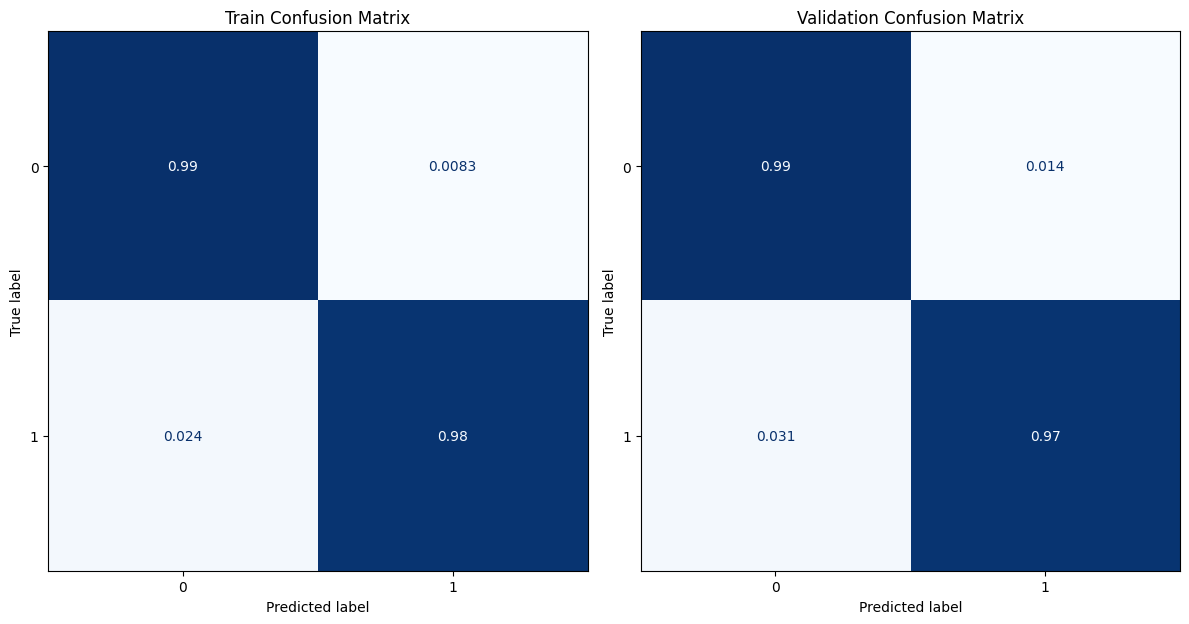

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.9830 │           0.9759 │
│ roc_auc  │      0.9985 │           0.9961 │
└──────────┴─────────────┴──────────────────┘

Cross-validation Results:

          Cross-validation Metrics          
┏━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Metric ┃ Mean Score ┃ Standard Deviation ┃
┡━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ f1     │     0.9752 │             0.0023 │
└────────┴────────────┴────────────────────┘

In [22]:
evaluate_model(log_reg_model_tfidf)

Бачимо, що модель демонструє дуже високі результати, що може свідчити про витік даних.
Спробуємо перемішати дані - випадкові фейкові/нефейкові позначки до ознак, позбавивши модель можливості вивчити реальні закономірності.


In [23]:
y_train_shuffled = y_train.sample(frac=1.0, random_state=42)
model = LogisticRegressionModel(
    X_train=X_train_count,
    y_train=y_train_shuffled,
    X_val=X_test_count,
    y_val=y_test
).fit().predict()

Running cross-validation before training...
Cross-validation f1: 0.4298 ± 0.0055


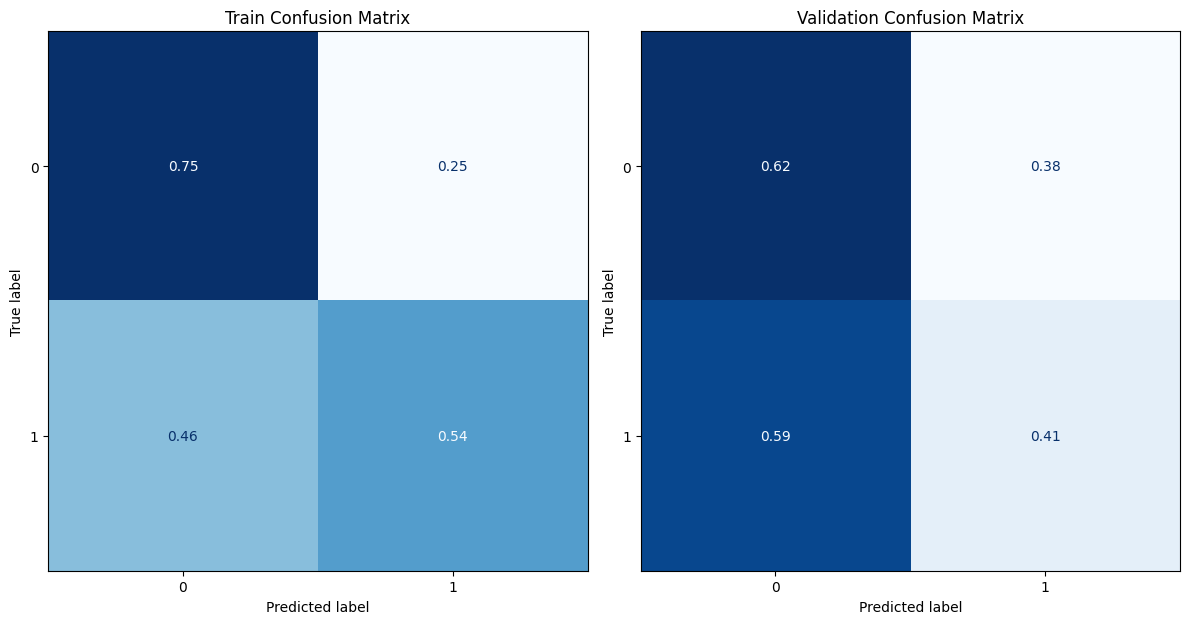

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.5833 │           0.4330 │
│ roc_auc  │      0.7089 │           0.4999 │
└──────────┴─────────────┴──────────────────┘

Cross-validation Results:

          Cross-validation Metrics          
┏━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Metric ┃ Mean Score ┃ Standard Deviation ┃
┡━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ f1     │     0.4298 │             0.0055 │
└────────┴────────────┴────────────────────┘

In [24]:
evaluate_model(model)

Спостереження: Бачимо, що результати метрик значно впали, отже маємо можливість зробити висновок, що результати минулої потенційно є справжніми, але певний витік все ж таки може мати місце. Наприклад, специфічні токени можуть бути все ж таки можуть бути присутні в моделі попри процесинг тексту.
Також можемо припустити, що такі високі результати при використанні простої моделі пов'язані з тим, що набір даних дотого ж добре збалансованим.


Подивимось на важливі слова, які найбільше впливають на результат класифікації новин, на прикладі CountVectorizer.

In [25]:
feature_names = count_vectorizer.vectorizer.get_feature_names_out()
coefs = log_reg_model_count.model.coef_[0]

top_fake_words = sorted(zip(feature_names, coefs), key=lambda x: x[1], reverse=True)[:20]
top_real_words = sorted(zip(feature_names, coefs), key=lambda x: x[1])[:20]

console = Console()

table_fake = Table(title="Top Words Indicating FAKE News")
table_fake.add_column("Word", style="red")
table_fake.add_column("Coefficient", justify="right")

for word, coef in top_fake_words:
    table_fake.add_row(word, f"{coef:.4f}")

table_real = Table(title="Top Words Indicating REAL News")
table_real.add_column("Word", style="green")
table_real.add_column("Coefficient", justify="right")

for word, coef in top_real_words:
    table_real.add_row(word, f"{coef:.4f}")

console.print(table_fake)
console.print(table_real)


 Top Words Indicating FAKE  
            News            
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Word       ┃ Coefficient ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ breaking   │      2.7416 │
│ gop        │      2.2476 │
│ video      │      2.0683 │
│ image      │      2.0154 │
│ wire       │      1.6030 │
│ sen        │      1.5086 │
│ reportedly │      1.4938 │
│ j          │      1.4867 │
│ gov        │      1.4684 │
│ breitbart  │      1.4591 │
│ 21st       │      1.4191 │
│ watch      │      1.3881 │
│ mr         │      1.3800 │
│ rep        │      1.3631 │
│ read       │      1.3548 │
│ seems      │      1.3286 │
│ dc         │      1.3099 │
│ taxpayer   │      1.2838 │
│ daily      │      1.2277 │
│ liberal    │      1.1856 │
└────────────┴─────────────┘

 Top Words Indicating REAL  
            News            
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Word       ┃ Coefficient ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ tuesday    │     -1.5886 │
│ wednesday  │     -1.5613 │
│ nov        │     -1.4886 │
│ factbox    │     -1.4436 │
│ thursday   │     -1.4148 │
│ friday     │     -1.3837 │
│ washington │     -1.3431 │
│ monday     │     -1.2042 │
│ rival      │     -1.1915 │
│ est        │     -1.1836 │
│ london     │     -1.1334 │
│ km         │     -1.1241 │
│ saturday   │     -1.1194 │
│ myanmar    │     -1.0722 │
│ said       │     -1.0141 │
│ rohingya   │     -1.0094 │
│ showed     │     -0.9785 │
│ edt        │     -0.9760 │
│ newspaper  │     -0.9485 │
│ paragraph  │     -0.9255 │
└────────────┴─────────────┘

Спостереження:
- Бачимо, що до слів з високими коефіцієнтами входять такі як breaking, watch, video, read, seems - потенційно, такі слова можуть привертати увагу, а отже використовуватись у фейкових новинах.
- Бачимо, що j, mr, 21st, taxpayer токени потрапили до ознак з найвищими коефіцієнтами. Виглядають такі токени досить дивними, але можливо саме вони є свого роду "артефактами" фейкових новин.
- До слів з найнижчими коефіцієнтами, що вказують на те, що новина не є фейковою увійшли дні тижня - що може говорити нам про реальні новини, де йде звіт по події за певні дні.
- Також низькі коефіцієнти мають географічні назви, що характерні для реальних репортажів та слова, характерні для формальних або журналістських публікацій типу factbox, newspaper, paragraph. І також нейтральні слова, типу мови повідомлень said, showed, rival.

В цілому можемо говорити, що модель розпізнає новини як правдиві по використанню в них стабільної та формальної лексики і використанню згадки про дні та локації. Тоді як використання клікбейтних слів більше схиляє модель до класифікації новини як фекової.

Щоб побачити наскільки добре модель розділяє фейкові та справжні новини, побудуємо розподіл передбачень від моделі розділений по справжніх класах.

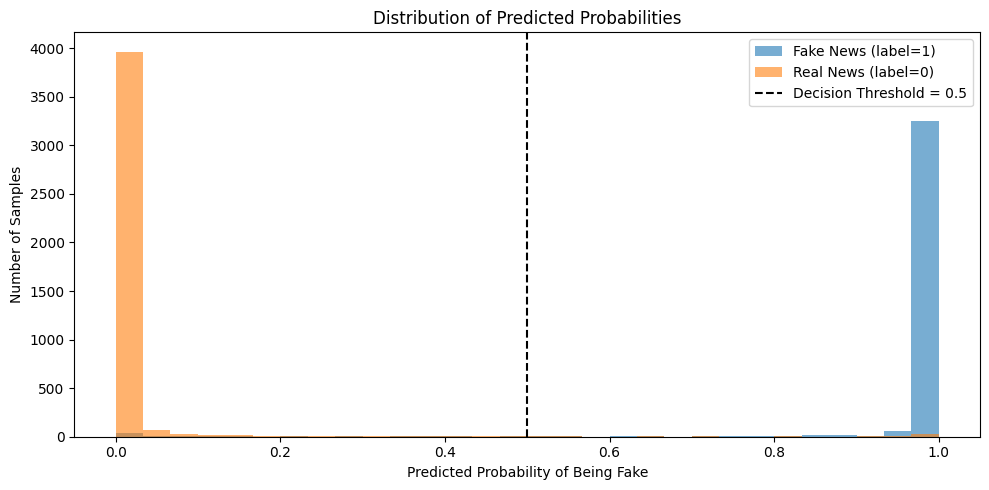

In [26]:
val_probs = log_reg_model_count.val_pr_proba
val_labels = log_reg_model_count.y_val

plt.figure(figsize=(10, 5))
plt.hist(val_probs[val_labels == 1], bins=30, alpha=0.6, label='Fake News (label=1)')
plt.hist(val_probs[val_labels == 0], bins=30, alpha=0.6, label='Real News (label=0)')
plt.axvline(0.5, color='black', linestyle='--', label='Decision Threshold = 0.5')
plt.xlabel("Predicted Probability of Being Fake")
plt.ylabel("Number of Samples")
plt.title("Distribution of Predicted Probabilities")
plt.legend()
plt.tight_layout()
plt.show()

Спостереження:
В цілому бачимо, що модель достатньо впевнена у своїх передбаченнях для обох класів. Оскільки, для фейкових новин бачимо, що дуже високі передбачені ймовірності — зосереджені біля 1.0, а для  реальних новин бачимо, що дуже низькі передбачені ймовірності — зосереджені біля 0.0. Зразків передбачення біля межі 0.5 майже не видно на графіку, що говорить нам, що побудована модель не вагається, а досить чітко визначає до якого класу належить новина.

Для додаткового експерименту подивимось як себе покаже на цій задачі xgboost

In [27]:
xgb_model_params = {"learning_rate": 0.05, "n_estimators": 50, "max_depth": 4}
xgb_model = XGBModel(X_train=X_train_tfidf, y_train=y_train,
                     X_val=X_test_tfidf, y_val=y_test,
                     params=xgb_model_params
                     ).fit().predict()

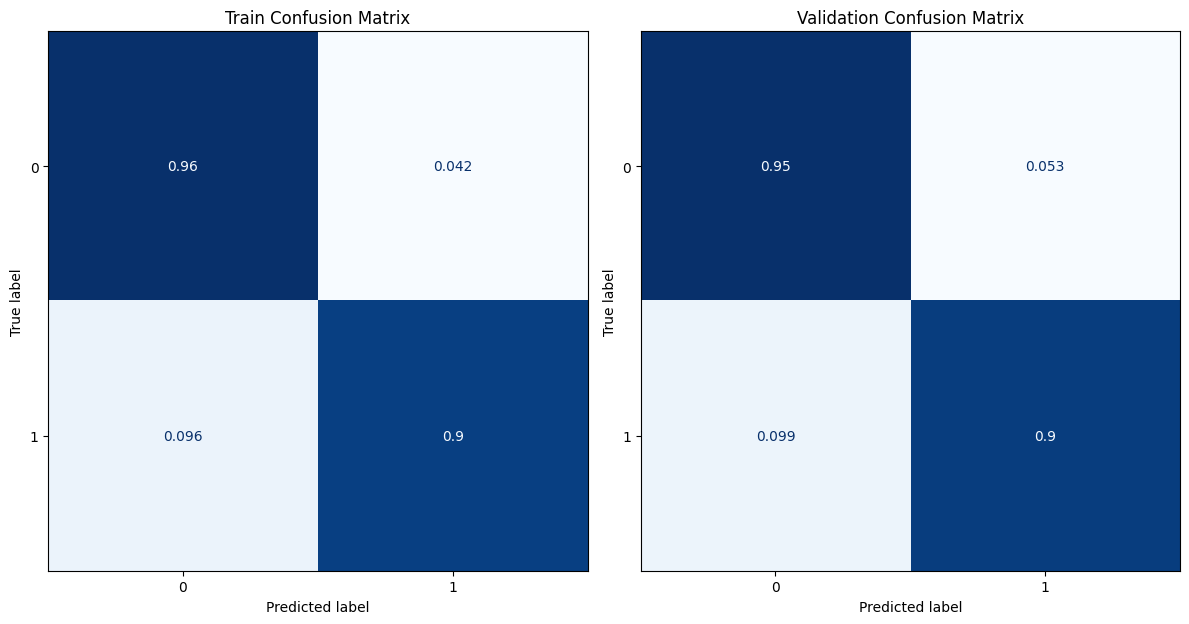

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.9244 │           0.9166 │
│ roc_auc  │      0.9816 │           0.9756 │
└──────────┴─────────────┴──────────────────┘

In [28]:
evaluate_model(xgb_model)

Спостереження:

Бачимо, що логістична регресія перевершила xgboost на цій задачі.
Можемо припустити, що такий результат обумовленний тим, що маємо багато розріджених фічей, на якому логістична регресія працює краще.
Також вірогідно, що дана задача не потребує використання складних структур для вирішення.

Спробуємо більш детально дослідити можливість витоку даних, адже результати моделей достатньо підозрілі.

In [29]:
fake_texts = df[df["is_fake"] == 1]["full_text"]
real_texts = df[df["is_fake"] == 0]["full_text"]

In [30]:
vectorizer = CountVectorizer(min_df=2, lowercase=True)
X_fake = vectorizer.fit_transform(fake_texts)
vocab_fake = np.array(vectorizer.get_feature_names_out())
counts_fake = np.array(X_fake.sum(axis=0)).flatten()

vectorizer = CountVectorizer(min_df=2, lowercase=True)
X_real = vectorizer.fit_transform(real_texts)
vocab_real = np.array(vectorizer.get_feature_names_out())
counts_real = np.array(X_real.sum(axis=0)).flatten()

In [31]:
only_in_fake = set(vocab_fake) - set(vocab_real)
only_in_real = set(vocab_real) - set(vocab_fake)

In [32]:
only_fake_counts = {word: count for word, count in zip(vocab_fake, counts_fake) if word in only_in_fake}
only_real_counts = {word: count for word, count in zip(vocab_real, counts_real) if word in only_in_real}

In [33]:
sorted_fake = sorted(only_fake_counts.items(), key=lambda x: x[1], reverse=True)
sorted_real = sorted(only_real_counts.items(), key=lambda x: x[1], reverse=True)

In [34]:
top_fake_only = sorted_fake[:20]
top_real_only = sorted_fake[:20]

print(top_fake_only)
print(top_real_only)

[('getty', 4138), ('https', 3503), ('21wire', 1081), ('quot', 1000), ('js', 887), ('flickr', 585), ('screengrab', 564), ('amp', 534), ('somodevilla', 466), ('2017the', 462), ('fjs', 441), ('ck', 426), ('antifa', 405), ('acr', 366), ('var', 364), ('cdata', 310), ('filessupport', 297), ('angerer', 281), ('mcnamee', 278), ('2017trump', 274)]
[('getty', 4138), ('https', 3503), ('21wire', 1081), ('quot', 1000), ('js', 887), ('flickr', 585), ('screengrab', 564), ('amp', 534), ('somodevilla', 466), ('2017the', 462), ('fjs', 441), ('ck', 426), ('antifa', 405), ('acr', 366), ('var', 364), ('cdata', 310), ('filessupport', 297), ('angerer', 281), ('mcnamee', 278), ('2017trump', 274)]


Наявність вставок типу https, getty, filessupport, fjs, cdata — це виглядає як витік, бо фактично вони не є суттєвими ознаками змісту, але для моделі вони можуть асоціюватися з фейком. Якщо модель бачить https, вона з великою ймовірністю ставить is_fake = 1.

Збережемо так використаємо в препроцесингу, спробуємо видалити значну частину найпопулярніших токенів притаманних кожній з груп, та подивимось на якість моделі, натренованих на таких даних.

In [35]:
def save_leaky_words(fake_counts: dict, real_counts: dict, path="../registry/vocabularies/leaky_words.json"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    leaky_data = {
        "fake_only": [word for word, count in fake_counts],
        "real_only": [word for word, count in real_counts]
    }

    with open(path, "w", encoding="utf-8") as f:
        json.dump(leaky_data, f, ensure_ascii=False, indent=2)

In [36]:
save_leaky_words(sorted_fake, sorted_real)

In [37]:
df_ = raw_df.copy()
df_.shape

(38639, 6)

In [38]:
df_["full_text"] = df_["title"] + " " + df_["text"]
df_ = df_.drop([col for col in ["title", "text", "date"] if col in df_.columns], axis=1)
df_.head(3)

,Unnamed: 0,is_fake,date_parsed,full_text
0,0,0,2017-09-17,Earthquake hits off Papua New Guinea LONDON (R...
1,1,1,2017-06-12,CINDY MCCAIN Reportedly Accepts Trump Administ...
2,2,0,2016-04-09,Prosecutors say ex-House Speaker Hastert sexua...


In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_[input_cols], df_[target_col], test_size=0.2, random_state=42,
                                                    stratify=df_[target_col])

In [40]:
from preprocessing.cleaning.text_cleaning import process_text_without_leaks

count_vectorizer = CountTextVectorizer(
    text_column="full_text",
    tokenizer=process_text_without_leaks,
    max_features=3000,
    min_df=3
)

X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [41]:
log_reg_model_count = LogisticRegressionModel(X_train=X_train_count, y_train=y_train, X_val=X_test_count,
                                              y_val=y_test).fit().predict()

Running cross-validation before training...
Cross-validation f1: 0.9743 ± 0.0018


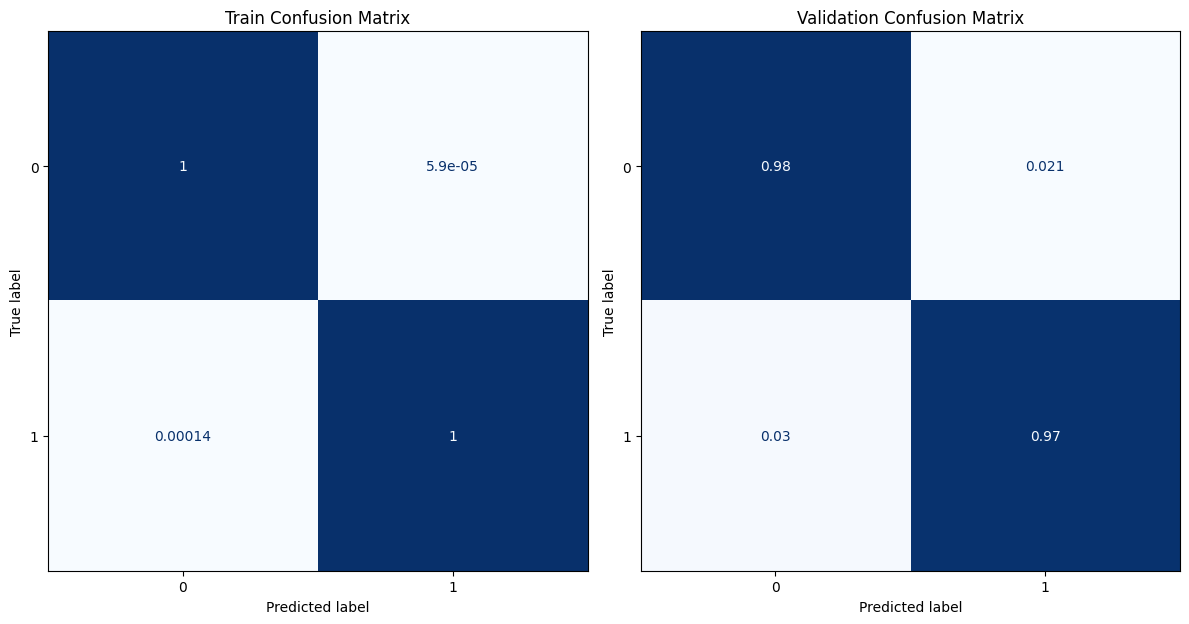

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.9999 │           0.9724 │
│ roc_auc  │      1.0000 │           0.9927 │
└──────────┴─────────────┴──────────────────┘

Cross-validation Results:

          Cross-validation Metrics          
┏━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Metric ┃ Mean Score ┃ Standard Deviation ┃
┡━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ f1     │     0.9743 │             0.0018 │
└────────┴────────────┴────────────────────┘

In [42]:
evaluate_model(log_reg_model_count)

Спостереження: спроба видалення частини токенів не призвела до покращення якості моделі

Висновки:

При побудові базової моделі було використано два підходи до векторизації тексту:
- TF-IDF, який зважує слова за частотою у документі та оберненою частотою у корпусі.
- CountVectorizer, що враховує частоту слів у документі, без врахування важливості.

Обидва методи створюють розріджені вектори ознак, які добре підходять для лінійних моделей. Обидва способи показали гарні результати при використанні, з якими найпростіша базова модель продемонструвала гарну якість передбачення.
Також на основі CountVectorizer підходу було проаналізовано вплив важливих слів що використовувала модель для класифікації новини, що дозволила побачити характерні патерни фейкових і реальних новин, які підтверджуються емпірично (наприклад, слова breaking, video, said, tuesday тощо).

Логістична регресія показала кращу узагальнювальну здатність, що можна пояснити лінійною природою TF-IDF-простору та перевагами регуляризації для sparse-даних. Натомість XGBoost виявився менш ефективним на таких фічах і частково схильним до перенавчання.